In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import regex as re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
#import pygwalker as pyg

train = pd.read_csv("/kaggle/input/laptop-price-prediction/laptops_train.csv")
test = pd.read_csv("/kaggle/input/laptop-price-prediction/laptops_test.csv")
train.head()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20


In [2]:
train.columns

Index(['Manufacturer', 'Model Name', 'Category', 'Screen Size', 'Screen',
       'CPU', 'RAM', ' Storage', 'GPU', 'Operating System',
       'Operating System Version', 'Weight', 'Price'],
      dtype='object')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Manufacturer              977 non-null    object 
 1   Model Name                977 non-null    object 
 2   Category                  977 non-null    object 
 3   Screen Size               977 non-null    object 
 4   Screen                    977 non-null    object 
 5   CPU                       977 non-null    object 
 6   RAM                       977 non-null    object 
 7    Storage                  977 non-null    object 
 8   GPU                       977 non-null    object 
 9   Operating System          977 non-null    object 
 10  Operating System Version  841 non-null    object 
 11  Weight                    977 non-null    object 
 12  Price                     977 non-null    float64
dtypes: float64(1), object(12)
memory usage: 99.4+ KB


In [4]:
train.describe()

,Price
count,9.770000e+02
mean,1.001899e+07
std,6.306430e+06
min,1.706375e+06
25%,5.326308e+06
50%,8.527428e+06
75%,1.311570e+07
max,5.423231e+07


In [5]:
train.isnull().sum() / len(train) * 100

Manufacturer                 0.000000
Model Name                   0.000000
Category                     0.000000
Screen Size                  0.000000
Screen                       0.000000
CPU                          0.000000
RAM                          0.000000
 Storage                     0.000000
GPU                          0.000000
Operating System             0.000000
Operating System Version    13.920164
Weight                       0.000000
Price                        0.000000
dtype: float64

# Data Cleaning

In [6]:
def extract_screen_features(train):
    train = train.rename(columns = str.lower)
    train["resolution"] = train["screen"].str.extract(r'(\d+x\d+)')
    train["screentype"]= train["screen"].replace(r'(\d+x\d+)','', regex = True)
    train['screentype'] = train['screentype'].replace(r'(Full HD|Quad HD|Quad HD|\+|/|4K Ultra HD)','', regex = True)
    train['touchscreen'] = train['screentype'].str.extract(r'(Touchscreen)')
    train['screentype'] = train['screentype'].replace(r'(Touchscreen)','', regex = True)
    train['touchscreen'] = train['touchscreen'].replace('Touchscreen', 1)
    train['touchscreen'] = train['touchscreen'].replace(np.nan, 0)
    train['screentype'] = train['screentype'].replace(r' ','', regex = True)
    train['screentype'] = train['screentype'].replace(r'^\s*$', np.nan, regex = True)
    train = train.drop("screen",axis = 1)
    return train

In [7]:
train = extract_screen_features(train)
test = extract_screen_features(test)

In [8]:
train.head()

,manufacturer,model name,category,screen size,cpu,ram,storage,gpu,operating system,operating system version,weight,price,resolution,screentype,touchscreen
0,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48,2560x1600,IPSPanelRetinaDisplay,0.0
1,Apple,Macbook Air,Ultrabook,"13.3""",Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48,1440x900,NaN,0.0
2,HP,250 G6,Notebook,"15.6""",Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00,1920x1080,NaN,0.0
3,Apple,MacBook Pro,Ultrabook,"15.4""",Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40,2880x1800,IPSPanelRetinaDisplay,0.0
4,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20,2560x1600,IPSPanelRetinaDisplay,0.0


In [9]:
test.head()

,manufacturer,model name,category,screen size,cpu,ram,storage,gpu,operating system,operating system version,weight,price,resolution,screentype,touchscreen
0,HP,15-bs053od (i7-7500U/6GB/1TB/W10),Notebook,"15.6""",Intel Core i7 7500U 2.7GHz,6GB,1TB HDD,Intel HD Graphics 620,Windows,10,2.04kg,5148468.0,1366x768,NaN,0.0
1,Asus,Rog GL753VE-DS74,Gaming,"17.3""",Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows,10,2.99kg,15552108.0,1920x1080,NaN,0.0
2,Dell,Inspiron 7579,2 in 1 Convertible,"15.6""",Intel Core i7 7500U 2.7GHz,12GB,512GB SSD,Intel HD Graphics 620,Windows,10,2.19kg,11550708.0,1920x1080,IPSPanel,1.0
3,Toshiba,Portege Z30-C-1CV,Notebook,"13.3""",Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows,7,1.2kg,10625940.0,1920x1080,NaN,0.0
4,Lenovo,IdeaPad 320-15ABR,Notebook,"15.6""",AMD A12-Series 9720P 3.6GHz,6GB,256GB SSD,AMD Radeon 530,Windows,10,2.2kg,4881708.0,1920x1080,NaN,0.0


In [10]:
def extract_from_cpu(train):
    train["freq"] = train["cpu"].str.extract(r'(\d+(?:\.\d+)?GHz)')
    train["freq"] = train["freq"].str.replace('GHz','')
    train["freq"] = train["freq"].astype(float)
    train["cpu"] = train["cpu"].str.replace(r'(\d+(?:\.\d+)?GHz)','',regex =True)
    return train

In [11]:
train = extract_from_cpu(train)
test = extract_from_cpu(test)

In [12]:
train.head()

,manufacturer,model name,category,screen size,cpu,ram,storage,gpu,operating system,operating system version,weight,price,resolution,screentype,touchscreen,freq
0,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48,2560x1600,IPSPanelRetinaDisplay,0.0,2.3
1,Apple,Macbook Air,Ultrabook,"13.3""",Intel Core i5,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48,1440x900,NaN,0.0,1.8
2,HP,250 G6,Notebook,"15.6""",Intel Core i5 7200U,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00,1920x1080,NaN,0.0,2.5
3,Apple,MacBook Pro,Ultrabook,"15.4""",Intel Core i7,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40,2880x1800,IPSPanelRetinaDisplay,0.0,2.7
4,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20,2560x1600,IPSPanelRetinaDisplay,0.0,3.1


In [13]:
test.head()

,manufacturer,model name,category,screen size,cpu,ram,storage,gpu,operating system,operating system version,weight,price,resolution,screentype,touchscreen,freq
0,HP,15-bs053od (i7-7500U/6GB/1TB/W10),Notebook,"15.6""",Intel Core i7 7500U,6GB,1TB HDD,Intel HD Graphics 620,Windows,10,2.04kg,5148468.0,1366x768,NaN,0.0,2.7
1,Asus,Rog GL753VE-DS74,Gaming,"17.3""",Intel Core i7 7700HQ,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows,10,2.99kg,15552108.0,1920x1080,NaN,0.0,2.8
2,Dell,Inspiron 7579,2 in 1 Convertible,"15.6""",Intel Core i7 7500U,12GB,512GB SSD,Intel HD Graphics 620,Windows,10,2.19kg,11550708.0,1920x1080,IPSPanel,1.0,2.7
3,Toshiba,Portege Z30-C-1CV,Notebook,"13.3""",Intel Core i5 6200U,4GB,128GB SSD,Intel HD Graphics 520,Windows,7,1.2kg,10625940.0,1920x1080,NaN,0.0,2.3
4,Lenovo,IdeaPad 320-15ABR,Notebook,"15.6""",AMD A12-Series 9720P,6GB,256GB SSD,AMD Radeon 530,Windows,10,2.2kg,4881708.0,1920x1080,NaN,0.0,3.6


In [14]:
train['ram'] = train['ram'].str.replace('GB','')
train['ram'] = train['ram'].astype(float)
train.head(3)


,manufacturer,model name,category,screen size,cpu,ram,storage,gpu,operating system,operating system version,weight,price,resolution,screentype,touchscreen,freq
0,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48,2560x1600,IPSPanelRetinaDisplay,0.0,2.3
1,Apple,Macbook Air,Ultrabook,"13.3""",Intel Core i5,8.0,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48,1440x900,NaN,0.0,1.8
2,HP,250 G6,Notebook,"15.6""",Intel Core i5 7200U,8.0,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00,1920x1080,NaN,0.0,2.5


In [15]:
test["ram"] = test["ram"].str.replace("GB", "")
test["ram"] = test["ram"].astype(float)
test.head()

,manufacturer,model name,category,screen size,cpu,ram,storage,gpu,operating system,operating system version,weight,price,resolution,screentype,touchscreen,freq
0,HP,15-bs053od (i7-7500U/6GB/1TB/W10),Notebook,"15.6""",Intel Core i7 7500U,6.0,1TB HDD,Intel HD Graphics 620,Windows,10,2.04kg,5148468.0,1366x768,NaN,0.0,2.7
1,Asus,Rog GL753VE-DS74,Gaming,"17.3""",Intel Core i7 7700HQ,16.0,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows,10,2.99kg,15552108.0,1920x1080,NaN,0.0,2.8
2,Dell,Inspiron 7579,2 in 1 Convertible,"15.6""",Intel Core i7 7500U,12.0,512GB SSD,Intel HD Graphics 620,Windows,10,2.19kg,11550708.0,1920x1080,IPSPanel,1.0,2.7
3,Toshiba,Portege Z30-C-1CV,Notebook,"13.3""",Intel Core i5 6200U,4.0,128GB SSD,Intel HD Graphics 520,Windows,7,1.2kg,10625940.0,1920x1080,NaN,0.0,2.3
4,Lenovo,IdeaPad 320-15ABR,Notebook,"15.6""",AMD A12-Series 9720P,6.0,256GB SSD,AMD Radeon 530,Windows,10,2.2kg,4881708.0,1920x1080,NaN,0.0,3.6


In [16]:
train[" storage"].value_counts()

256GB SSD                        318
1TB HDD                          171
512GB SSD                         91
500GB HDD                         79
128GB SSD +  1TB HDD              71
128GB SSD                         62
256GB SSD +  1TB HDD              52
32GB Flash Storage                29
2TB HDD                           14
512GB SSD +  1TB HDD              13
1TB SSD                           11
256GB SSD +  2TB HDD              10
64GB Flash Storage                 9
16GB Flash Storage                 6
256GB Flash Storage                5
32GB SSD                           5
128GB Flash Storage                4
1GB SSD                            4
256GB SSD +  256GB SSD             2
16GB SSD                           2
1TB SSD +  1TB HDD                 2
512GB SSD +  2TB HDD               2
128GB SSD +  2TB HDD               2
512GB SSD +  512GB SSD             1
512GB SSD +  256GB SSD             1
64GB SSD                           1
64GB Flash Storage +  1TB HDD      1
2

In [17]:
def extract_from_storage(train):
    train["storage1"] = train[" storage"]
    train['storage1'] = train['storage1'].str.replace('1.0TB','1TB', regex = True)
    train['storage1'] = train['storage1'].str.replace('1TB','1000GB')
    train['storage1'] = train['storage1'].str.replace('2TB','2000GB')
    train['storage1'] = train['storage1'].str.replace('GB','')
    train['storage2'] = train['storage1'].str.replace(r' ','')
    storage1 = []
    storage2 = []
    for i in train['storage2']:
        if len(re.findall(r'\+', i)) == 1: 
            # Double drive
            one = re.findall(r'(\w+)', i)
            storage1.append(one[0])
            storage2.append(one[1])
        else: 
            # Single drive
            one = re.findall(r'(\w+)', i)
            storage1.append(one[0])
            storage2.append('NaN')


    #extracting size and type of primary storage
    storage1size = []
    storage1type = []
    for i in storage1:
        storage1type.append(re.findall(r'(\D\w+)', i)[0])
        storage1size.append(re.findall(r'(\d+)', i)[0])


    #extracting size and type of secondary storage
    storage2size = []
    storage2type = []
    for i in storage2:
        if i != 'NaN':
            storage2type.append(re.findall(r'(\D\w+)',i)[0])
            storage2size.append(re.findall(r'(\d+)',i)[0])
        else:
            storage2type.append('NaN')
            storage2size.append(0)
    train['primarystorage_size'] = storage1size
    train['primarystorage_type'] = storage1type
    train['secondarystorage_size'] = storage2size
    train['secondarystorage_type'] = storage2type
    
    train["primarystorage_size"] = train["primarystorage_size"].astype(float)
    train["secondarystorage_size"] = train["secondarystorage_size"].astype(float)
    train = train.drop(['storage1','storage2',' storage'], axis = 1)
    train = train.replace({'NaN' : np.nan})
    return train

In [18]:
train = extract_from_storage(train)
test = extract_from_storage(test)

In [19]:
train.head()

,manufacturer,model name,category,screen size,cpu,ram,gpu,operating system,operating system version,weight,price,resolution,screentype,touchscreen,freq,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type
0,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN
1,Apple,Macbook Air,Ultrabook,"13.3""",Intel Core i5,8.0,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN
2,HP,250 G6,Notebook,"15.6""",Intel Core i5 7200U,8.0,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN
3,Apple,MacBook Pro,Ultrabook,"15.4""",Intel Core i7,16.0,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN
4,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN


In [20]:
test.head()

,manufacturer,model name,category,screen size,cpu,ram,gpu,operating system,operating system version,weight,price,resolution,screentype,touchscreen,freq,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type
0,HP,15-bs053od (i7-7500U/6GB/1TB/W10),Notebook,"15.6""",Intel Core i7 7500U,6.0,Intel HD Graphics 620,Windows,10,2.04kg,5148468.0,1366x768,NaN,0.0,2.7,1000.0,HDD,0.0,NaN
1,Asus,Rog GL753VE-DS74,Gaming,"17.3""",Intel Core i7 7700HQ,16.0,Nvidia GeForce GTX 1050 Ti,Windows,10,2.99kg,15552108.0,1920x1080,NaN,0.0,2.8,256.0,SSD,1000.0,HDD
2,Dell,Inspiron 7579,2 in 1 Convertible,"15.6""",Intel Core i7 7500U,12.0,Intel HD Graphics 620,Windows,10,2.19kg,11550708.0,1920x1080,IPSPanel,1.0,2.7,512.0,SSD,0.0,NaN
3,Toshiba,Portege Z30-C-1CV,Notebook,"13.3""",Intel Core i5 6200U,4.0,Intel HD Graphics 520,Windows,7,1.2kg,10625940.0,1920x1080,NaN,0.0,2.3,128.0,SSD,0.0,NaN
4,Lenovo,IdeaPad 320-15ABR,Notebook,"15.6""",AMD A12-Series 9720P,6.0,AMD Radeon 530,Windows,10,2.2kg,4881708.0,1920x1080,NaN,0.0,3.6,256.0,SSD,0.0,NaN


In [21]:
train.columns

Index(['manufacturer', 'model name', 'category', 'screen size', 'cpu', 'ram',
       'gpu', 'operating system', 'operating system version', 'weight',
       'price', 'resolution', 'screentype', 'touchscreen', 'freq',
       'primarystorage_size', 'primarystorage_type', 'secondarystorage_size',
       'secondarystorage_type'],
      dtype='object')

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   manufacturer              977 non-null    object 
 1   model name                977 non-null    object 
 2   category                  977 non-null    object 
 3   screen size               977 non-null    object 
 4   cpu                       977 non-null    object 
 5   ram                       977 non-null    float64
 6   gpu                       977 non-null    object 
 7   operating system          977 non-null    object 
 8   operating system version  841 non-null    object 
 9   weight                    977 non-null    object 
 10  price                     977 non-null    float64
 11  resolution                977 non-null    object 
 12  screentype                280 non-null    object 
 13  touchscreen               977 non-null    float64
 14  freq      

In [23]:
train["weight"].value_counts()

2.2kg     98
2.1kg     45
2.5kg     32
2kg       31
2.4kg     27
          ..
2.29kg     1
0.97kg     1
3.25kg     1
1.14kg     1
1.70kg     1
Name: weight, Length: 166, dtype: int64

In [24]:
def clean_weight(train):
    train['weight'] = train['weight'].str.replace('kg','')
    train['weight'] = train['weight'].str.replace('s', '').astype(float)
    return train

In [25]:
train = clean_weight(train)
test = clean_weight(test)

In [26]:
train.head()

,manufacturer,model name,category,screen size,cpu,ram,gpu,operating system,operating system version,weight,price,resolution,screentype,touchscreen,freq,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type
0,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,Intel Iris Plus Graphics 640,macOS,NaN,1.37,11912523.48,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN
1,Apple,Macbook Air,Ultrabook,"13.3""",Intel Core i5,8.0,Intel HD Graphics 6000,macOS,NaN,1.34,7993374.48,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN
2,HP,250 G6,Notebook,"15.6""",Intel Core i5 7200U,8.0,Intel HD Graphics 620,No OS,NaN,1.86,5112900.00,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN
3,Apple,MacBook Pro,Ultrabook,"15.4""",Intel Core i7,16.0,AMD Radeon Pro 455,macOS,NaN,1.83,22563005.40,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN
4,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,Intel Iris Plus Graphics 650,macOS,NaN,1.37,16037611.20,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN


In [27]:
test.head()

,manufacturer,model name,category,screen size,cpu,ram,gpu,operating system,operating system version,weight,price,resolution,screentype,touchscreen,freq,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type
0,HP,15-bs053od (i7-7500U/6GB/1TB/W10),Notebook,"15.6""",Intel Core i7 7500U,6.0,Intel HD Graphics 620,Windows,10,2.04,5148468.0,1366x768,NaN,0.0,2.7,1000.0,HDD,0.0,NaN
1,Asus,Rog GL753VE-DS74,Gaming,"17.3""",Intel Core i7 7700HQ,16.0,Nvidia GeForce GTX 1050 Ti,Windows,10,2.99,15552108.0,1920x1080,NaN,0.0,2.8,256.0,SSD,1000.0,HDD
2,Dell,Inspiron 7579,2 in 1 Convertible,"15.6""",Intel Core i7 7500U,12.0,Intel HD Graphics 620,Windows,10,2.19,11550708.0,1920x1080,IPSPanel,1.0,2.7,512.0,SSD,0.0,NaN
3,Toshiba,Portege Z30-C-1CV,Notebook,"13.3""",Intel Core i5 6200U,4.0,Intel HD Graphics 520,Windows,7,1.20,10625940.0,1920x1080,NaN,0.0,2.3,128.0,SSD,0.0,NaN
4,Lenovo,IdeaPad 320-15ABR,Notebook,"15.6""",AMD A12-Series 9720P,6.0,AMD Radeon 530,Windows,10,2.20,4881708.0,1920x1080,NaN,0.0,3.6,256.0,SSD,0.0,NaN


In [28]:
def manufacturer(train):
    train['cpu_manftr'] = train['cpu'].str.extract(r'^(\w+)') 
    train['gpu_manftr'] = train['gpu'].str.extract(r'^(\w+)') 
    return train

In [29]:
train = manufacturer(train)
test = manufacturer(test)

In [30]:
train.head()

,manufacturer,model name,category,screen size,cpu,ram,gpu,operating system,operating system version,weight,...,resolution,screentype,touchscreen,freq,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type,cpu_manftr,gpu_manftr
0,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,Intel Iris Plus Graphics 640,macOS,NaN,1.37,...,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN,Intel,Intel
1,Apple,Macbook Air,Ultrabook,"13.3""",Intel Core i5,8.0,Intel HD Graphics 6000,macOS,NaN,1.34,...,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN,Intel,Intel
2,HP,250 G6,Notebook,"15.6""",Intel Core i5 7200U,8.0,Intel HD Graphics 620,No OS,NaN,1.86,...,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN,Intel,Intel
3,Apple,MacBook Pro,Ultrabook,"15.4""",Intel Core i7,16.0,AMD Radeon Pro 455,macOS,NaN,1.83,...,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN,Intel,AMD
4,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,Intel Iris Plus Graphics 650,macOS,NaN,1.37,...,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN,Intel,Intel


In [31]:
test.head()

,manufacturer,model name,category,screen size,cpu,ram,gpu,operating system,operating system version,weight,...,resolution,screentype,touchscreen,freq,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type,cpu_manftr,gpu_manftr
0,HP,15-bs053od (i7-7500U/6GB/1TB/W10),Notebook,"15.6""",Intel Core i7 7500U,6.0,Intel HD Graphics 620,Windows,10,2.04,...,1366x768,NaN,0.0,2.7,1000.0,HDD,0.0,NaN,Intel,Intel
1,Asus,Rog GL753VE-DS74,Gaming,"17.3""",Intel Core i7 7700HQ,16.0,Nvidia GeForce GTX 1050 Ti,Windows,10,2.99,...,1920x1080,NaN,0.0,2.8,256.0,SSD,1000.0,HDD,Intel,Nvidia
2,Dell,Inspiron 7579,2 in 1 Convertible,"15.6""",Intel Core i7 7500U,12.0,Intel HD Graphics 620,Windows,10,2.19,...,1920x1080,IPSPanel,1.0,2.7,512.0,SSD,0.0,NaN,Intel,Intel
3,Toshiba,Portege Z30-C-1CV,Notebook,"13.3""",Intel Core i5 6200U,4.0,Intel HD Graphics 520,Windows,7,1.20,...,1920x1080,NaN,0.0,2.3,128.0,SSD,0.0,NaN,Intel,Intel
4,Lenovo,IdeaPad 320-15ABR,Notebook,"15.6""",AMD A12-Series 9720P,6.0,AMD Radeon 530,Windows,10,2.20,...,1920x1080,NaN,0.0,3.6,256.0,SSD,0.0,NaN,AMD,AMD


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   manufacturer              977 non-null    object 
 1   model name                977 non-null    object 
 2   category                  977 non-null    object 
 3   screen size               977 non-null    object 
 4   cpu                       977 non-null    object 
 5   ram                       977 non-null    float64
 6   gpu                       977 non-null    object 
 7   operating system          977 non-null    object 
 8   operating system version  841 non-null    object 
 9   weight                    977 non-null    float64
 10  price                     977 non-null    float64
 11  resolution                977 non-null    object 
 12  screentype                280 non-null    object 
 13  touchscreen               977 non-null    float64
 14  freq      

In [33]:
test.head()

,manufacturer,model name,category,screen size,cpu,ram,gpu,operating system,operating system version,weight,...,resolution,screentype,touchscreen,freq,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type,cpu_manftr,gpu_manftr
0,HP,15-bs053od (i7-7500U/6GB/1TB/W10),Notebook,"15.6""",Intel Core i7 7500U,6.0,Intel HD Graphics 620,Windows,10,2.04,...,1366x768,NaN,0.0,2.7,1000.0,HDD,0.0,NaN,Intel,Intel
1,Asus,Rog GL753VE-DS74,Gaming,"17.3""",Intel Core i7 7700HQ,16.0,Nvidia GeForce GTX 1050 Ti,Windows,10,2.99,...,1920x1080,NaN,0.0,2.8,256.0,SSD,1000.0,HDD,Intel,Nvidia
2,Dell,Inspiron 7579,2 in 1 Convertible,"15.6""",Intel Core i7 7500U,12.0,Intel HD Graphics 620,Windows,10,2.19,...,1920x1080,IPSPanel,1.0,2.7,512.0,SSD,0.0,NaN,Intel,Intel
3,Toshiba,Portege Z30-C-1CV,Notebook,"13.3""",Intel Core i5 6200U,4.0,Intel HD Graphics 520,Windows,7,1.20,...,1920x1080,NaN,0.0,2.3,128.0,SSD,0.0,NaN,Intel,Intel
4,Lenovo,IdeaPad 320-15ABR,Notebook,"15.6""",AMD A12-Series 9720P,6.0,AMD Radeon 530,Windows,10,2.20,...,1920x1080,NaN,0.0,3.6,256.0,SSD,0.0,NaN,AMD,AMD


In [34]:
train.to_csv("laptop-clean-train.csv", index = False)
test.to_csv("laptop-clean-test.csv", index = False)

# EDA

In [35]:
df1 = pd.read_csv("laptop-clean-train.csv")
df1.head()

,manufacturer,model name,category,screen size,cpu,ram,gpu,operating system,operating system version,weight,...,resolution,screentype,touchscreen,freq,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type,cpu_manftr,gpu_manftr
0,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,Intel Iris Plus Graphics 640,macOS,NaN,1.37,...,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN,Intel,Intel
1,Apple,Macbook Air,Ultrabook,"13.3""",Intel Core i5,8.0,Intel HD Graphics 6000,macOS,NaN,1.34,...,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN,Intel,Intel
2,HP,250 G6,Notebook,"15.6""",Intel Core i5 7200U,8.0,Intel HD Graphics 620,No OS,NaN,1.86,...,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN,Intel,Intel
3,Apple,MacBook Pro,Ultrabook,"15.4""",Intel Core i7,16.0,AMD Radeon Pro 455,macOS,NaN,1.83,...,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN,Intel,AMD
4,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,Intel Iris Plus Graphics 650,macOS,NaN,1.37,...,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN,Intel,Intel


In [36]:
df_clean = df1.copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   manufacturer              977 non-null    object 
 1   model name                977 non-null    object 
 2   category                  977 non-null    object 
 3   screen size               977 non-null    object 
 4   cpu                       977 non-null    object 
 5   ram                       977 non-null    float64
 6   gpu                       977 non-null    object 
 7   operating system          977 non-null    object 
 8   operating system version  841 non-null    object 
 9   weight                    977 non-null    float64
 10  price                     977 non-null    float64
 11  resolution                977 non-null    object 
 12  screentype                280 non-null    object 
 13  touchscreen               977 non-null    float64
 14  freq      

In [37]:
def num_plot(df, col, title, symb):
    fig, ax = plt.subplots(2, 1, sharex = True, figsize = (8,5),gridspec_kw = {"height_ratios": (.2, .8)})
    ax[0].set_title(title)
    sns.boxplot(x = col, data = df, ax = ax[0])
    ax[0].set(yticks = [])
    sns.histplot(x = col, data = df, ax = ax[1])
    ax[1].set_xlabel(col)
    plt.axvline(df[col].mean(), color = 'darkgreen', label = 'mean=' + str(np.round(df[col].mean(),1)) + symb)
    plt.axvline(df[col].median(), color = 'red', label = 'median='+ str(np.round(df[col].median(),1)) + symb)
    plt.axvline(df[col].mode()[0], color = 'purple', label = 'mode='+ str(df[col].mode()[0]) + symb)
    plt.legend(bbox_to_anchor = (1, 1.03), ncol = 1, fancybox = True, shadow = True, frameon = True)
    plt.tight_layout()
    plt.show()

# Which brand is the most frequent in the dataframe?

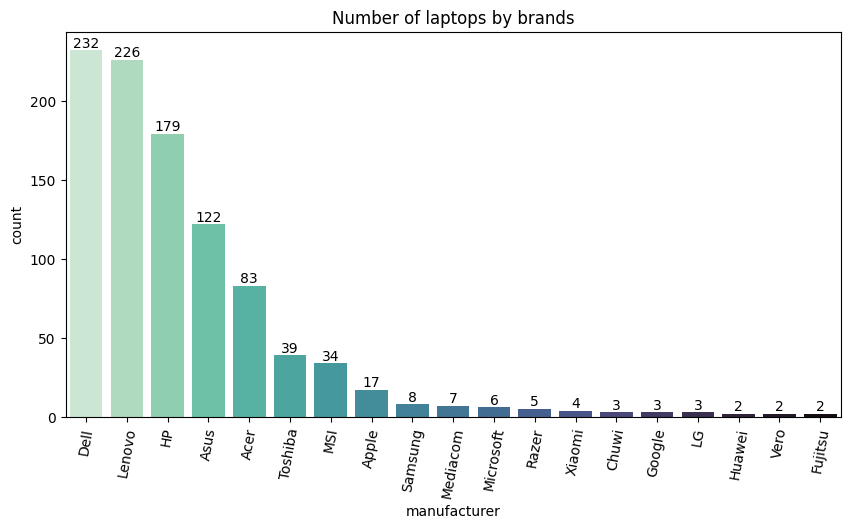

In [38]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.countplot(x = "manufacturer", data = train, palette = "mako_r", order = train["manufacturer"].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80)
ax.bar_label(ax.containers[0])
plt.title("Number of laptops by brands")
plt.show()

# Which type of laptops is the most frequent?

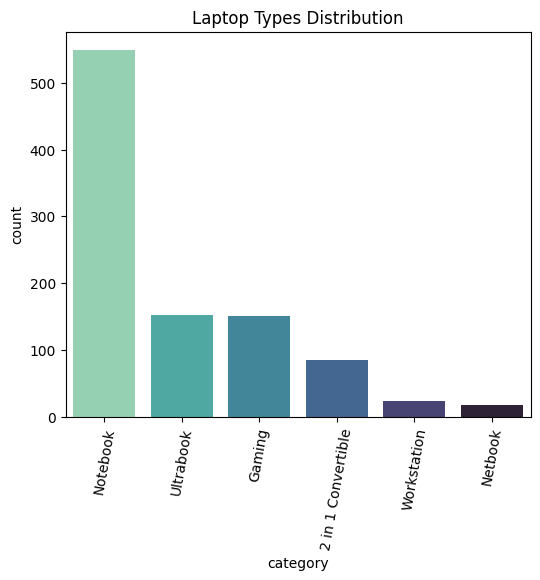

In [39]:
fig, ax = plt.subplots(figsize = (6, 5))
ax = sns.countplot(x = "category", data = train, palette = "mako_r", order = train["category"].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80)
plt.title("Laptop Types Distribution")
plt.show()

# Which size of laptops is the most occuring?

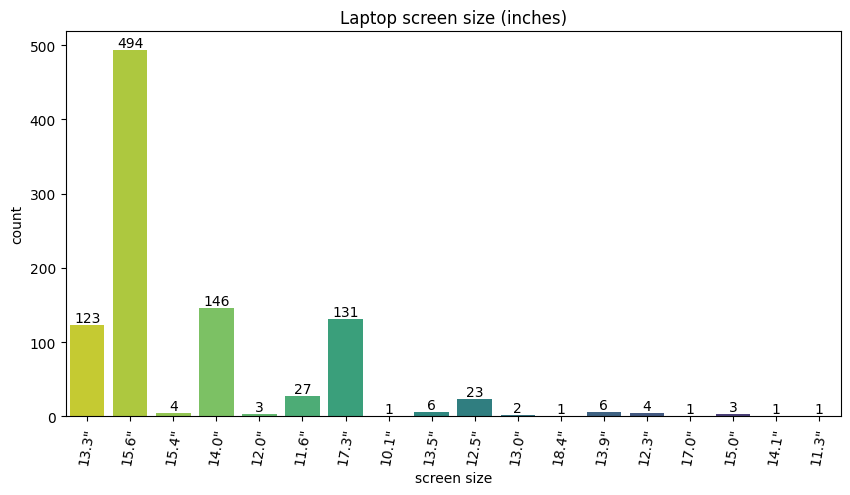

In [40]:
fig, ax  = plt.subplots(figsize = (10,5))
ax=sns.countplot(x = 'screen size', data = train, palette = 'viridis_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80);
ax.bar_label(ax.containers[0])
plt.title('Laptop screen size (inches)')
plt.show()

# Outliers Engineering in Screen Size distrubtion

In [41]:
inches_list = train["screen size"].value_counts().index[:6].tolist()
inches_list

['15.6"', '14.0"', '17.3"', '13.3"', '11.6"', '12.5"']

In [42]:
df_clean = df_clean[df_clean['screen size'].isin(inches_list)]

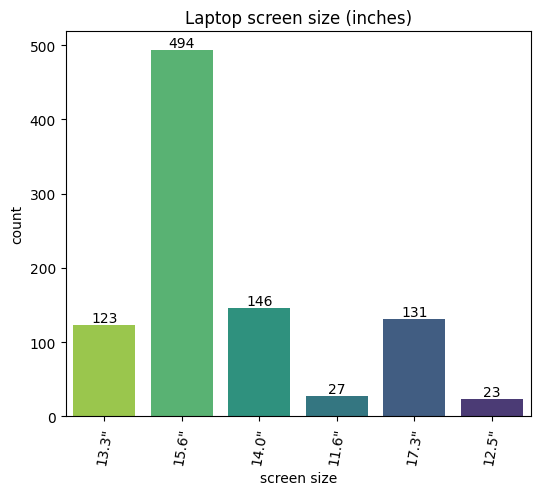

In [43]:
fig, ax  = plt.subplots(figsize = (6,5))
ax=sns.countplot(x = 'screen size', data = df_clean, palette = 'viridis_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80);
ax.bar_label(ax.containers[0])
plt.title('Laptop screen size (inches)')
plt.show()

In [44]:
print("We removed {} outliers!".format(len(train) - len(df_clean)))

We removed 33 outliers!


# Weight distribution

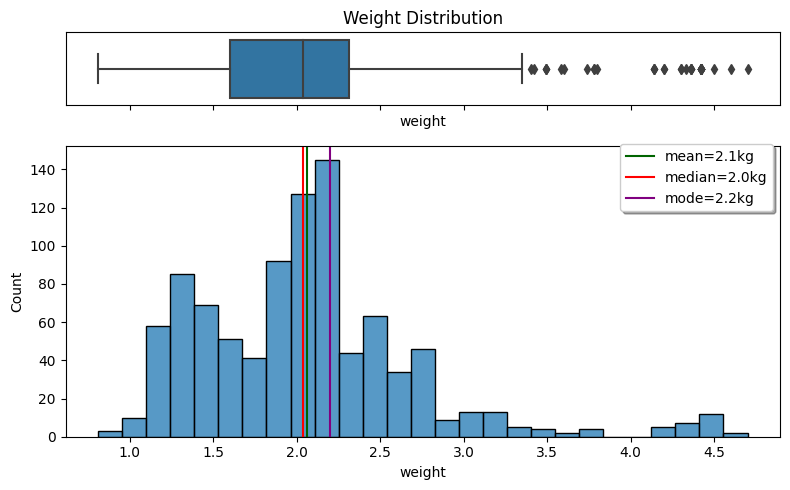

In [45]:
num_plot(df_clean, "weight", "Weight Distribution", "kg")

# How is price distributed among the laptops?

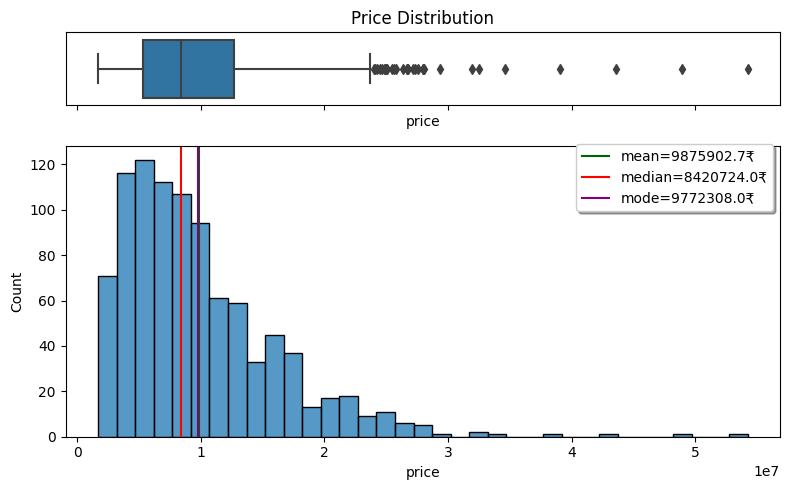

In [46]:
num_plot(df_clean, "price", "Price Distribution", '₹')

In [47]:
import plotly.express as px
fig = px.box(train, y = "price")
fig.show()

In [48]:
train.columns

Index(['manufacturer', 'model name', 'category', 'screen size', 'cpu', 'ram',
       'gpu', 'operating system', 'operating system version', 'weight',
       'price', 'resolution', 'screentype', 'touchscreen', 'freq',
       'primarystorage_size', 'primarystorage_type', 'secondarystorage_size',
       'secondarystorage_type', 'cpu_manftr', 'gpu_manftr'],
      dtype='object')

<AxesSubplot: xlabel='category', ylabel='price'>

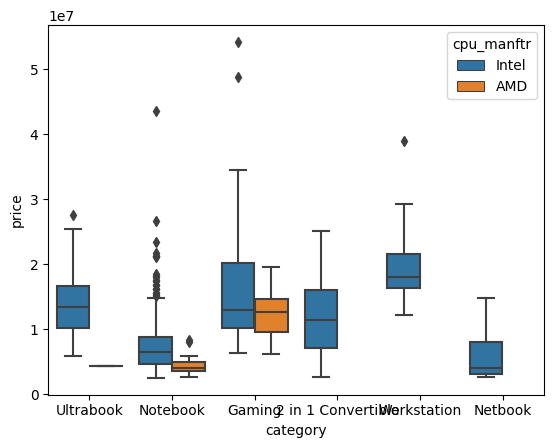

In [49]:
sns.boxplot(x = 'category', y = 'price', data = train[train['price'] > 2500000], hue = 'cpu_manftr')

In [50]:
train[train['price'] > 2500000]

,manufacturer,model name,category,screen size,cpu,ram,gpu,operating system,operating system version,weight,...,resolution,screentype,touchscreen,freq,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type,cpu_manftr,gpu_manftr
0,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,Intel Iris Plus Graphics 640,macOS,NaN,1.37,...,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN,Intel,Intel
1,Apple,Macbook Air,Ultrabook,"13.3""",Intel Core i5,8.0,Intel HD Graphics 6000,macOS,NaN,1.34,...,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN,Intel,Intel
2,HP,250 G6,Notebook,"15.6""",Intel Core i5 7200U,8.0,Intel HD Graphics 620,No OS,NaN,1.86,...,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN,Intel,Intel
3,Apple,MacBook Pro,Ultrabook,"15.4""",Intel Core i7,16.0,AMD Radeon Pro 455,macOS,NaN,1.83,...,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN,Intel,AMD
4,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,Intel Iris Plus Graphics 650,macOS,NaN,1.37,...,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN,Intel,Intel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Alienware 17,Gaming,"17.3""",Intel Core i7 6700HQ,32.0,Nvidia GeForce GTX 1070,Windows,10,4.42,...,1920x1080,NaN,0.0,2.6,256.0,SSD,1000.0,HDD,Intel,Nvidia
973,Toshiba,Tecra A40-C-1DF,Notebook,"14.0""",Intel Core i5 6200U,8.0,Intel HD Graphics 520,Windows,10,1.95,...,1920x1080,NaN,0.0,2.3,256.0,SSD,0.0,NaN,Intel,Intel
974,Asus,Rog Strix,Gaming,"17.3""",Intel Core i7 7700HQ,16.0,Nvidia GeForce GTX 1060,Windows,10,2.73,...,1920x1080,NaN,0.0,2.8,256.0,SSD,1000.0,HDD,Intel,Nvidia
975,HP,Probook 450,Notebook,"15.6""",Intel Core i5 7200U,8.0,Nvidia GeForce 930MX,Windows,10,2.04,...,1920x1080,IPSPanel,0.0,2.7,128.0,SSD,1000.0,HDD,Intel,Nvidia


# How is RAM distributed amongst the laptops?

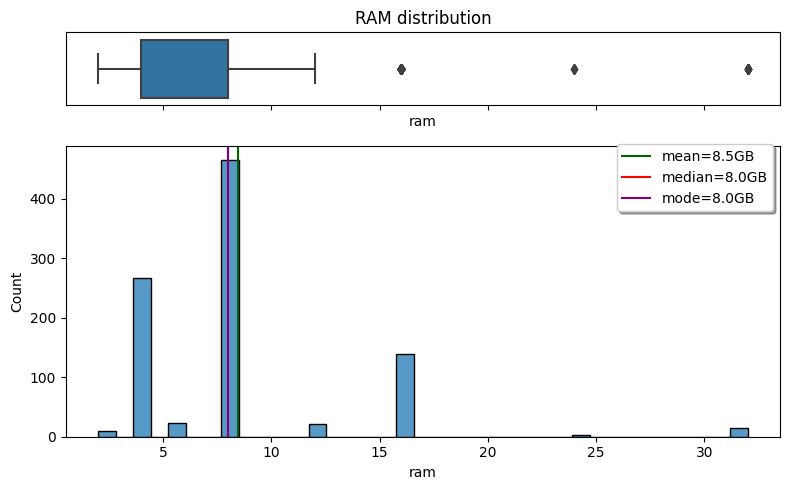

In [51]:
num_plot(df_clean, "ram", "RAM distribution", "GB")

# How is CPU frequency distributed among the laptops?

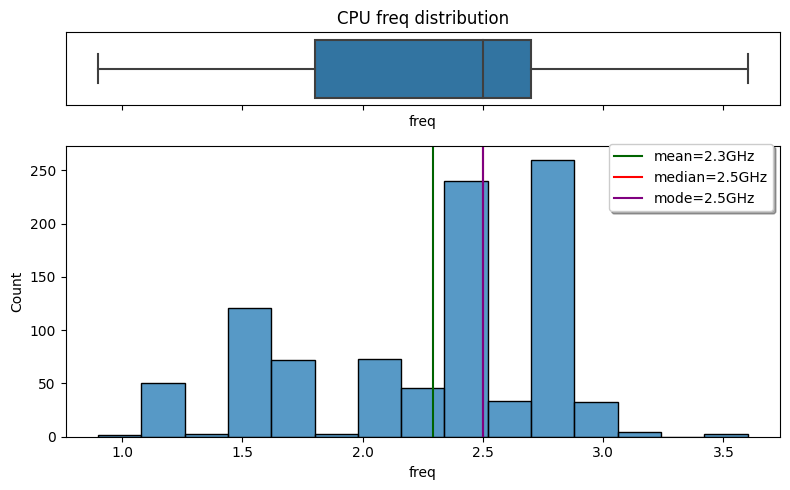

In [52]:
num_plot(df_clean, "freq", "CPU freq distribution", "GHz")

# How is Hard Drive capacity distributed among the laptops?

In [53]:
train.columns

Index(['manufacturer', 'model name', 'category', 'screen size', 'cpu', 'ram',
       'gpu', 'operating system', 'operating system version', 'weight',
       'price', 'resolution', 'screentype', 'touchscreen', 'freq',
       'primarystorage_size', 'primarystorage_type', 'secondarystorage_size',
       'secondarystorage_type', 'cpu_manftr', 'gpu_manftr'],
      dtype='object')

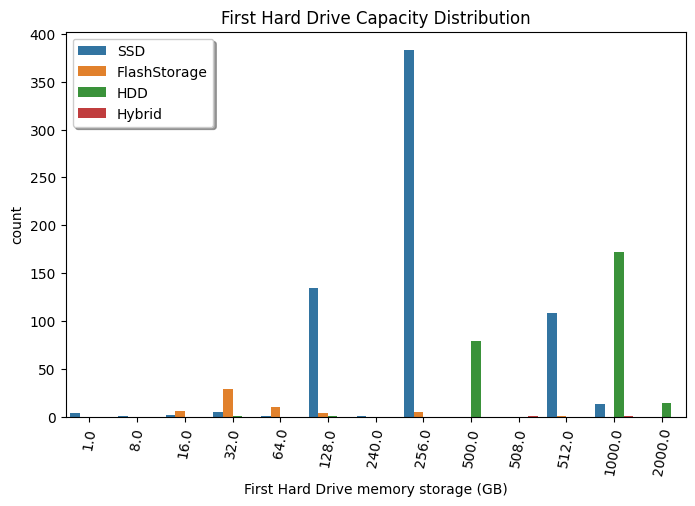

In [54]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.countplot(x = "primarystorage_size", data = train, hue = "primarystorage_type")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80)
ax.set_xlabel("First Hard Drive memory storage (GB)")
plt.title("First Hard Drive Capacity Distribution")
plt.legend(loc = "upper left", ncol = 1, fancybox = True, shadow = True, frameon = True)
plt.show()

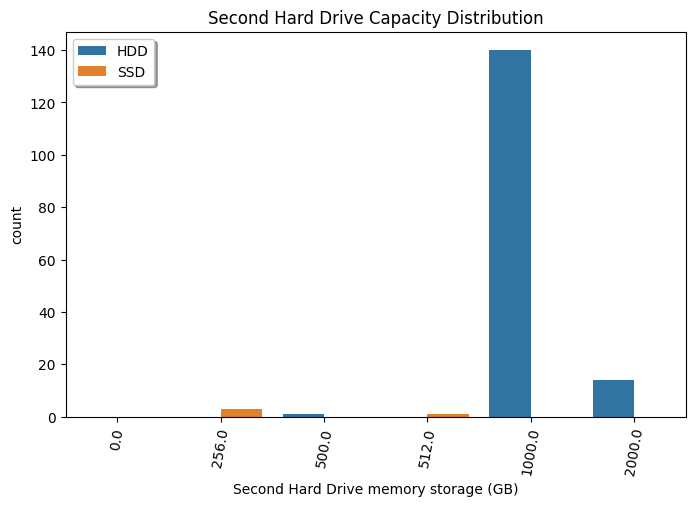

In [55]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.countplot(x = "secondarystorage_size", data = train, hue = "secondarystorage_type")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80)
ax.set_xlabel("Second Hard Drive memory storage (GB)")
plt.title("Second Hard Drive Capacity Distribution")
plt.legend(loc = "upper left", ncol = 1, fancybox = True, shadow = True, frameon = True)
plt.show()

# Multivariate outliers detection

# Price VS RAM

In [56]:
def lr_plot(df, col_x, col_y, leg):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[col_x],df[col_y])
    sns.regplot(x = col_x, y = col_y, data = df, color='#0d98ba', line_kws = {'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend(loc = leg, ncol = 1, fancybox = True, shadow = True, frameon = True)
    plt.title(col_y + ' VS ' + col_x)
    plt.show()

    return slope, intercept

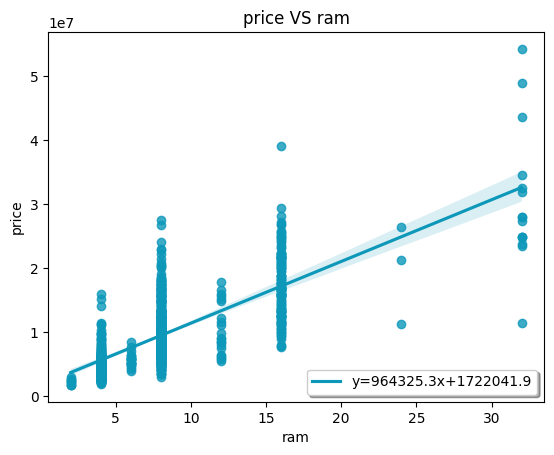

In [57]:
slope, intercept = lr_plot(df_clean, "ram", "price", "lower right")

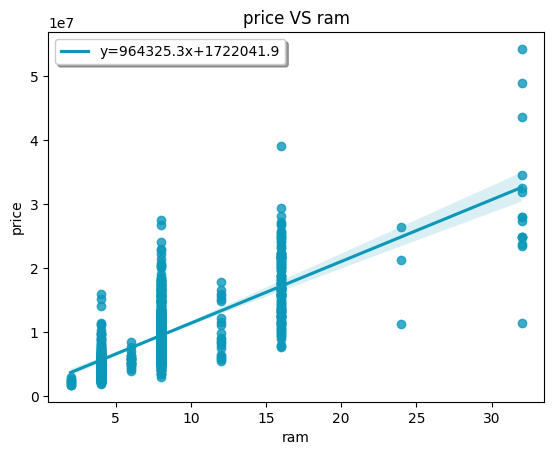

In [58]:
slope, intercept = lr_plot(df_clean, "ram", "price", "upper left")

# Price VS CPU Frequency

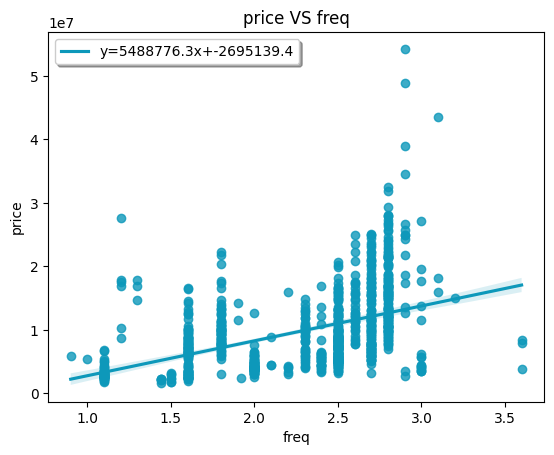

In [59]:
slope, intercept = lr_plot(df_clean, "freq", "price", "upper left")

# Price VS Inches

<AxesSubplot: xlabel='screen size', ylabel='price'>

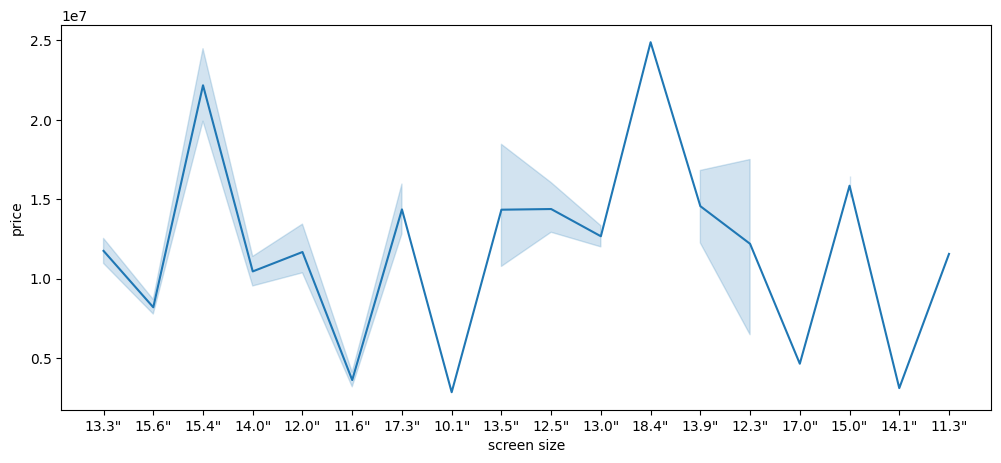

In [60]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.lineplot(x = "screen size", y = "price", data = train)

# Price vs CPU brand by GPU brand

In [61]:
train.columns

Index(['manufacturer', 'model name', 'category', 'screen size', 'cpu', 'ram',
       'gpu', 'operating system', 'operating system version', 'weight',
       'price', 'resolution', 'screentype', 'touchscreen', 'freq',
       'primarystorage_size', 'primarystorage_type', 'secondarystorage_size',
       'secondarystorage_type', 'cpu_manftr', 'gpu_manftr'],
      dtype='object')

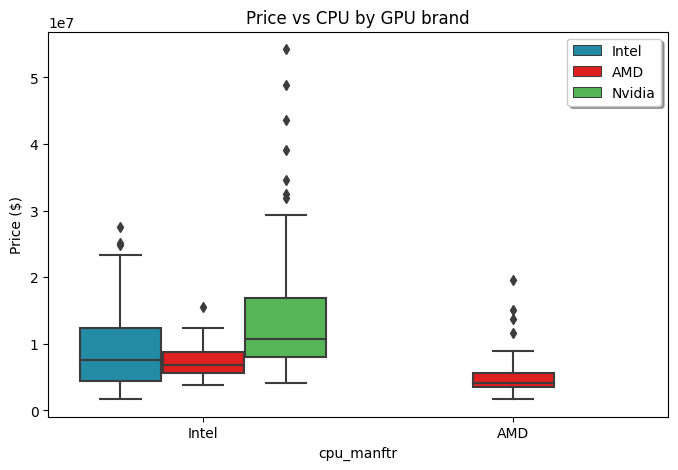

In [62]:
cpu_palette = {'Intel':'#0d98ba', 'AMD':'#FF0000', 'Nvidia':'#46C646'}
fig, ax = plt.subplots(figsize = (8, 5))
sns.boxplot(x = "cpu_manftr", y = "price", data = df_clean, hue = "gpu_manftr", palette = cpu_palette)
ax.set_title("Price vs CPU by GPU brand")
plt.ylabel("Price ($)")
plt.legend(loc = "upper right", ncol = 1, fancybox = True, shadow = True, frameon = True)
plt.title("Price vs CPU by GPU brand")
plt.show()

/tmp/ipykernel_20/2672431050.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_20/2672431050.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



[Text(0.5, 0, 'cpu'),
 Text(0, 0.5, 'Selling Price ($)'),
 Text(0.5, 1.0, 'Top 10 most expensive CPUs')]

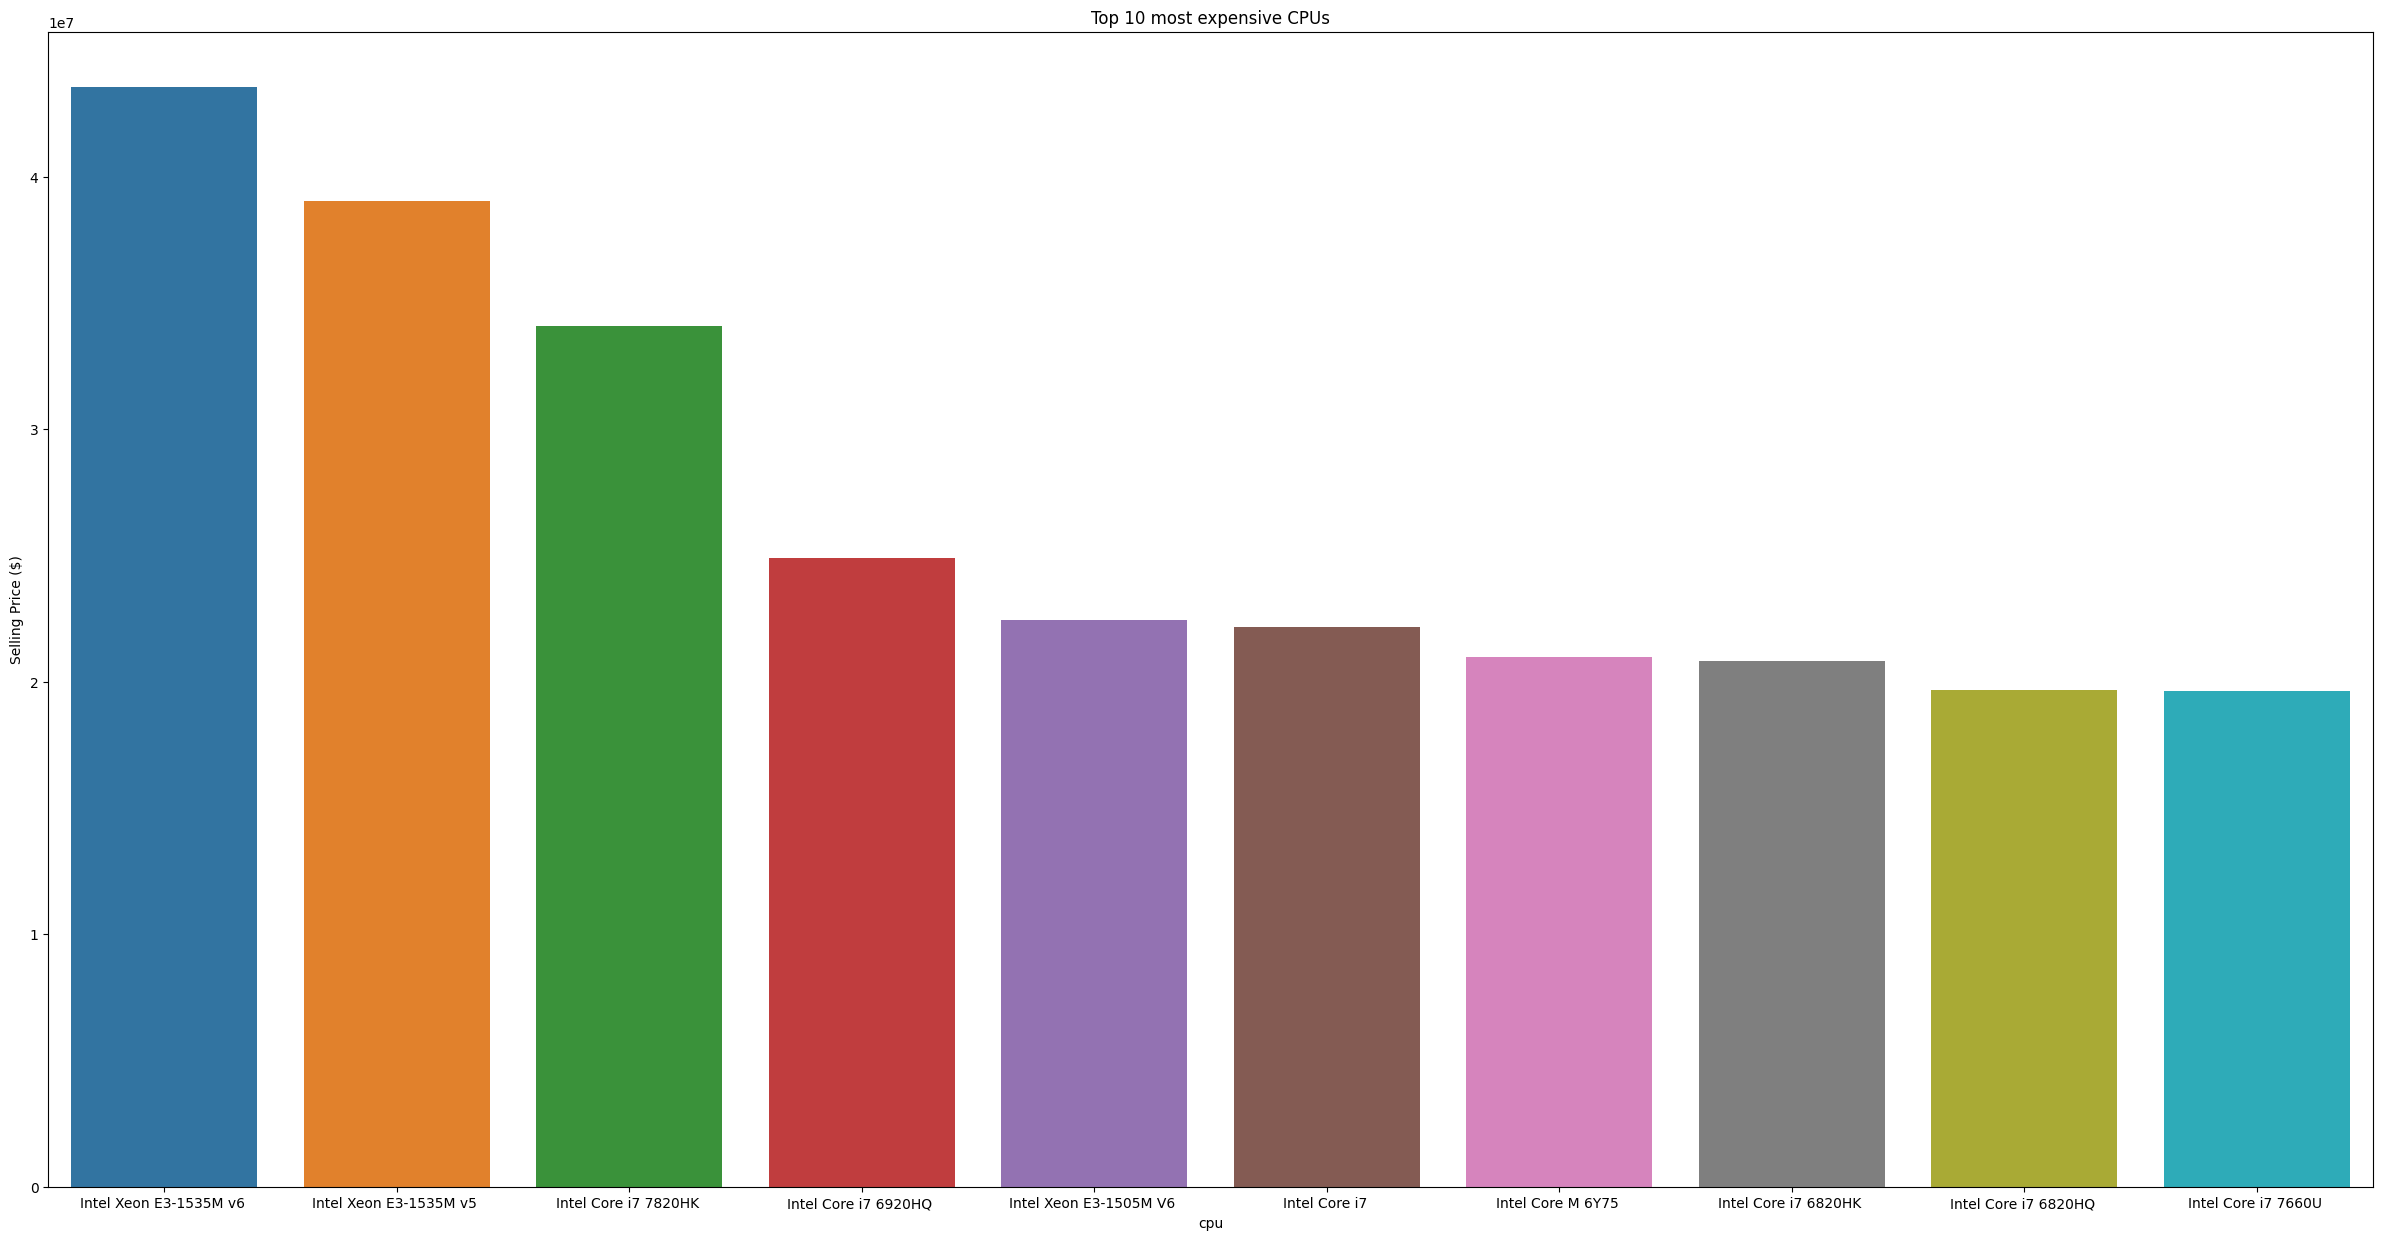

In [63]:
fig, ax = plt.subplots(figsize=(30, 15))
ax = sns.barplot(x=train.groupby('cpu').mean()['price'].sort_values(ascending=False)[:10].index, y=train.groupby('cpu').mean()['price'].sort_values(ascending=False)[:10].values)
ax.set(xlabel='cpu', ylabel="Selling Price ($)", title='Top 10 most expensive CPUs')

/tmp/ipykernel_20/4191524843.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_20/4191524843.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



[Text(0.5, 0, 'GPU'),
 Text(0, 0.5, 'Selling Price ($)'),
 Text(0.5, 1.0, 'Top 10 most expensive GPUs')]

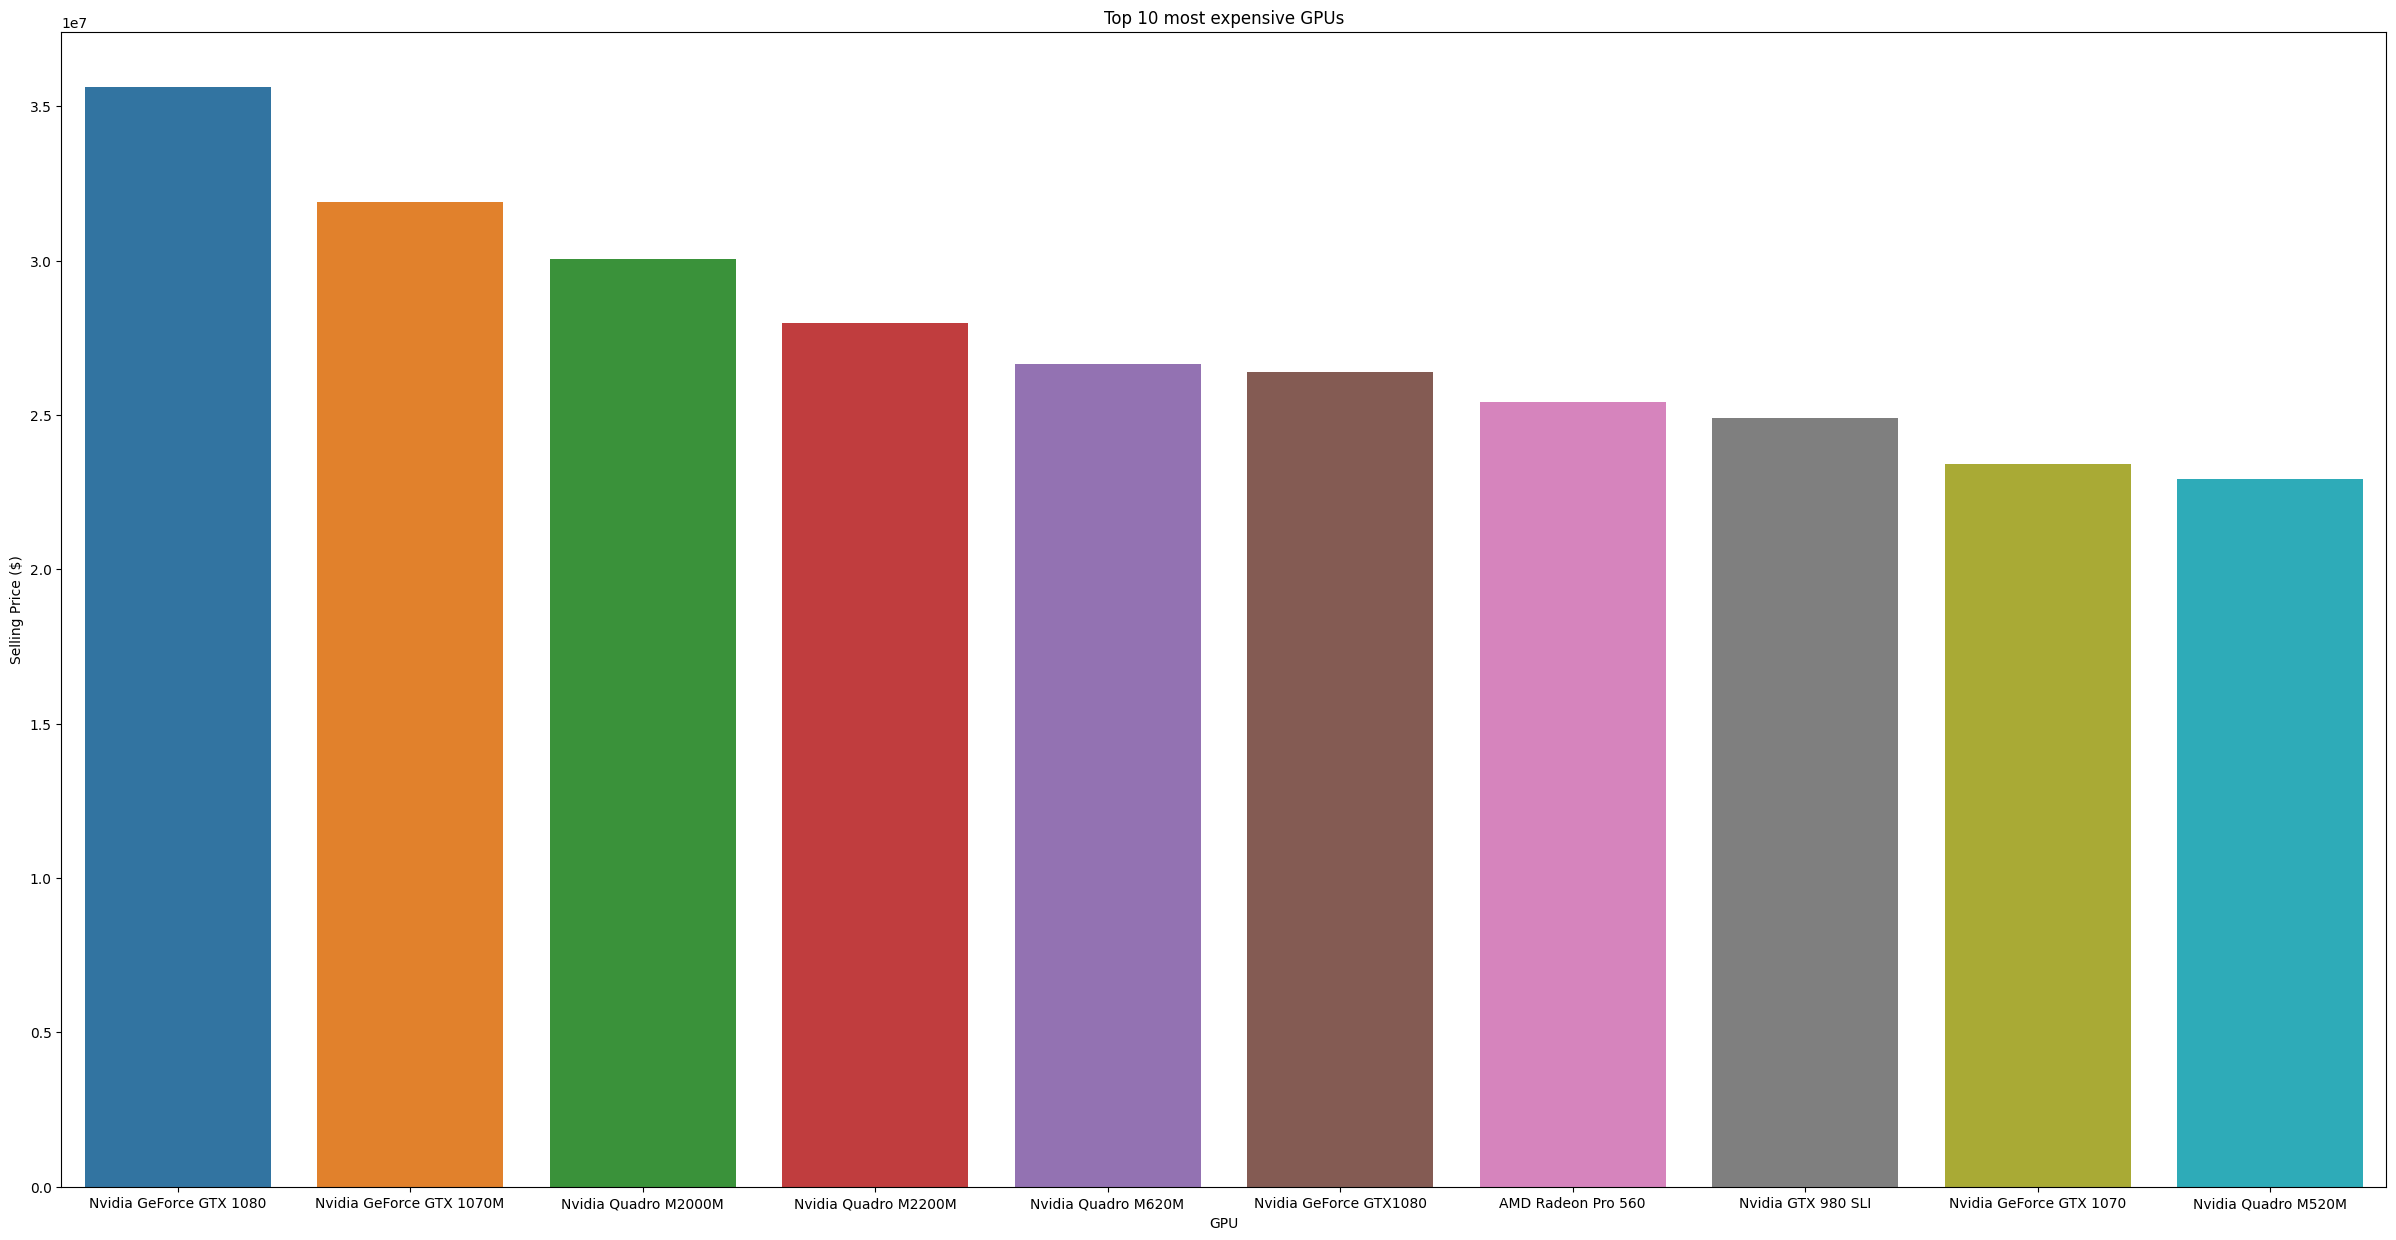

In [64]:
fig, ax = plt.subplots(figsize = (30, 15))
ax = sns.barplot(x=train.groupby('gpu').mean()['price'].sort_values(ascending=False)[:10].index, y=train.groupby('gpu').mean()['price'].sort_values(ascending=False)[:10].values)
ax.set(xlabel = "GPU", ylabel = "Selling Price ($)", title = "Top 10 most expensive GPUs")

# What is the average price of laptops per company?

In [65]:
df_clean["manufacturer"].value_counts()

Dell        232
Lenovo      218
HP          178
Asus        121
Acer         83
Toshiba      39
MSI          33
Apple        10
Mediacom      7
Razer         5
Samsung       5
Xiaomi        4
LG            3
Chuwi         2
Vero          2
Fujitsu       2
Name: manufacturer, dtype: int64

In [66]:
company_list = df_clean["manufacturer"].value_counts().index[:9].tolist()
company_list

['Dell', 'Lenovo', 'HP', 'Asus', 'Acer', 'Toshiba', 'MSI', 'Apple', 'Mediacom']

#### We can observe that DELL manufacturer company is the most occurring, it means that customers are getting used to this company. Furthermore, Lenovo, HP up to Mediacom. We need to analyze the relationship between those manufacturers and the price which is being used for the customers.

/tmp/ipykernel_20/2963083988.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.




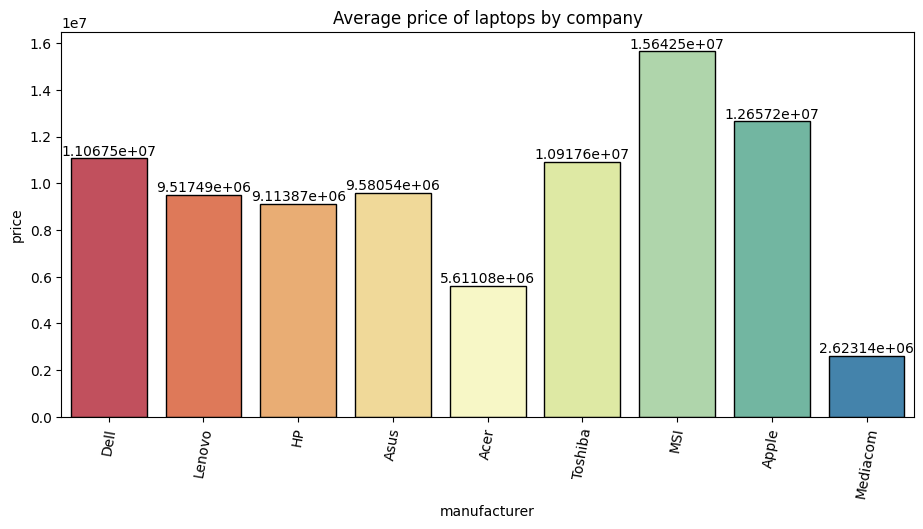

In [67]:
plt.figure(figsize = (11,5))
ax=sns.barplot(x = 'manufacturer', y = 'price', data = df_clean[df_clean['manufacturer'].isin(company_list)],
                order = company_list, 
                palette = 'Spectral', 
                ci = False,
                edgecolor = "black")
plt.xticks(rotation = 80);
ax.bar_label(ax.containers[0])
plt.title('Average price of laptops by company')
plt.show()

**The graph explains itself.**

# Correlation Matrix

/tmp/ipykernel_20/395549188.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



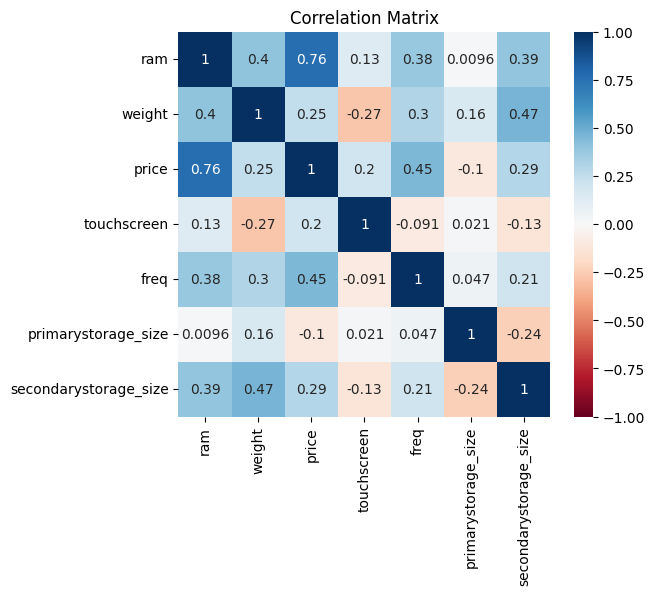

In [68]:
plt.figure(figsize = (6, 5))
sns.heatmap(df_clean.corr(), cmap = "RdBu", annot = True, vmin = -1, vmax = 1)
plt.title("Correlation Matrix")
plt.show()

### Based on the correlation matrix, we can observe that RAM affects price the most. Henceforth, customers tend to ask about the RAM before they buy the laptop.

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#FFFFFF'></span></b> 4. Data Preparation </b></p>
</div>

In [69]:
data = train.append(test)

/tmp/ipykernel_20/3862322379.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [70]:
data

,manufacturer,model name,category,screen size,cpu,ram,gpu,operating system,operating system version,weight,...,resolution,screentype,touchscreen,freq,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type,cpu_manftr,gpu_manftr
0,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,Intel Iris Plus Graphics 640,macOS,NaN,1.37,...,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN,Intel,Intel
1,Apple,Macbook Air,Ultrabook,"13.3""",Intel Core i5,8.0,Intel HD Graphics 6000,macOS,NaN,1.34,...,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN,Intel,Intel
2,HP,250 G6,Notebook,"15.6""",Intel Core i5 7200U,8.0,Intel HD Graphics 620,No OS,NaN,1.86,...,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN,Intel,Intel
3,Apple,MacBook Pro,Ultrabook,"15.4""",Intel Core i7,16.0,AMD Radeon Pro 455,macOS,NaN,1.83,...,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN,Intel,AMD
4,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5,8.0,Intel Iris Plus Graphics 650,macOS,NaN,1.37,...,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN,Intel,Intel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,"14.0""",Intel Core i7 6500U,4.0,Intel HD Graphics 520,Windows,10,1.80,...,1920x1080,IPSPanel,1.0,2.5,128.0,SSD,0.0,NaN,Intel,Intel
321,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,"13.3""",Intel Core i7 6500U,16.0,Intel HD Graphics 520,Windows,10,1.30,...,3200x1800,IPSPanel,1.0,2.5,512.0,SSD,0.0,NaN,Intel,Intel
322,Lenovo,IdeaPad 100S-14IBR,Notebook,"14.0""",Intel Celeron Dual Core N3050,2.0,Intel HD Graphics,Windows,10,1.50,...,1366x768,NaN,0.0,1.6,64.0,FlashStorage,0.0,NaN,Intel,Intel
323,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,"15.6""",Intel Core i7 6500U,6.0,AMD Radeon R5 M330,Windows,10,2.19,...,1366x768,NaN,0.0,2.5,1000.0,HDD,0.0,NaN,Intel,AMD


In [71]:
data["screen size"] = data["screen size"].str.replace('"', "")
data["screen size"] = data["screen size"].astype(float)

In [72]:
data = data.fillna("NaN")

In [73]:
data.isnull().sum() / len(data) * 100

manufacturer                0.0
model name                  0.0
category                    0.0
screen size                 0.0
cpu                         0.0
ram                         0.0
gpu                         0.0
operating system            0.0
operating system version    0.0
weight                      0.0
price                       0.0
resolution                  0.0
screentype                  0.0
touchscreen                 0.0
freq                        0.0
primarystorage_size         0.0
primarystorage_type         0.0
secondarystorage_size       0.0
secondarystorage_type       0.0
cpu_manftr                  0.0
gpu_manftr                  0.0
dtype: float64

In [74]:
data.columns

Index(['manufacturer', 'model name', 'category', 'screen size', 'cpu', 'ram',
       'gpu', 'operating system', 'operating system version', 'weight',
       'price', 'resolution', 'screentype', 'touchscreen', 'freq',
       'primarystorage_size', 'primarystorage_type', 'secondarystorage_size',
       'secondarystorage_type', 'cpu_manftr', 'gpu_manftr'],
      dtype='object')

In [75]:
cat_cols = ['manufacturer', 'model name', 'category', 'cpu','gpu', 'operating system', 'operating system version', 
    'screentype','primarystorage_type',"resolution",
 'secondarystorage_type', 'cpu_manftr', 'gpu_manftr']

In [76]:
# One Hot Encoding
print("Dataframe encoded by OHE : ", pd.get_dummies(data, columns = cat_cols, drop_first = True).shape)

Dataframe encoded by OHE :  (1302, 885)


In [77]:
# Label Enoding
en = LabelEncoder()

for cols in cat_cols:
    data[cols] = en.fit_transform(data[cols])
    
print("Dataframe encoded by Label Encoder: ", data.shape)

Dataframe encoded by Label Encoder:  (1302, 21)


In [78]:
data.head()

,manufacturer,model name,category,screen size,cpu,ram,gpu,operating system,operating system version,weight,...,resolution,screentype,touchscreen,freq,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type,cpu_manftr,gpu_manftr
0,1,300,4,13.3,51,8.0,58,6,3,1.37,...,10,1,0.0,2.3,128.0,3,0.0,2,1,2
1,1,301,4,13.3,51,8.0,51,6,3,1.34,...,1,2,0.0,1.8,128.0,0,0.0,2,1,2
2,7,50,3,15.6,57,8.0,53,4,3,1.86,...,3,2,0.0,2.5,256.0,3,0.0,2,1,2
3,1,300,4,15.4,65,16.0,9,6,3,1.83,...,12,1,0.0,2.7,512.0,3,0.0,2,1,0
4,1,300,4,13.3,51,8.0,59,6,3,1.37,...,10,1,0.0,3.1,256.0,3,0.0,2,1,2


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302 entries, 0 to 324
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   manufacturer              1302 non-null   int64  
 1   model name                1302 non-null   int64  
 2   category                  1302 non-null   int64  
 3   screen size               1302 non-null   float64
 4   cpu                       1302 non-null   int64  
 5   ram                       1302 non-null   float64
 6   gpu                       1302 non-null   int64  
 7   operating system          1302 non-null   int64  
 8   operating system version  1302 non-null   int64  
 9   weight                    1302 non-null   float64
 10  price                     1302 non-null   float64
 11  resolution                1302 non-null   int64  
 12  screentype                1302 non-null   int64  
 13  touchscreen               1302 non-null   float64
 14  freq     

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#FFFFFF'></span></b> 5. Splitting the Data </b></p>
</div>

In [80]:
X = data.drop("price", axis = 1)
y = data["price"]

In [81]:
X.shape

(1302, 20)

In [82]:
y.shape

(1302,)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 0)

In [84]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1236, 20) (66, 20) (1236,) (66,)


<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#FFFFFF'></span></b> 6. Modeling </b></p>
</div>

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [86]:
lr = LinearRegression()
dtree = DecisionTreeRegressor()
lgbmr = LGBMRegressor()
xgbr = XGBRegressor()

In [87]:
lr.fit(X_train, y_train)
dtree.fit(X_train, y_train)
lgbmr.fit(X_train, y_train)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [88]:
lr_pred = lr.predict(X_test)
print("r2_score:", r2_score(y_test, lr_pred))

r2_score: 0.6461237149372452


In [89]:
dtree_pred = dtree.predict(X_test)
print("r2_score: ", r2_score(y_test, dtree_pred))

r2_score:  0.7880708057108412


In [90]:
lgbmr_pred = lgbmr.predict(X_test)
print("r2_score: ", r2_score(y_test, lgbmr_pred))

r2_score:  0.8133075633168719


In [91]:
xgbr_pred = xgbr.predict(X_test)
print("r2_score: ", r2_score(y_test, xgbr_pred))

r2_score:  0.8629719169090204


In [92]:
xgbr_pred

array([ 2819260.2, 13002746. , 14388788. ,  5113792.5, 18206234. ,
        4840300. ,  3333740. ,  2685360.8, 10125225. , 26800724. ,
        9601211. ,  5759518. ,  2338638. , 11306715. , 23165034. ,
        7235092. ,  6074309.5, 17119806. , 17667034. , 18128386. ,
        3262414.2,  6505986. ,  5680748.5, 11485545. ,  4836410.5,
        6581255.5,  6703142.5,  8655293. ,  6944805.5, 11476187. ,
       11368042. ,  6384912. , 11865951. ,  7541949. , 18617678. ,
       11167111. , 24587380. ,  4001507.5, 11429341. , 14953006. ,
       13941814. , 10214431. , 41477416. ,  9344400. , 10821035. ,
        5467602. , 10865337. ,  7139718. , 12374745. ,  3727600. ,
        7163322.5, 25172580. ,  4056372.5,  9834653. ,  6731684. ,
       10921317. ,  2726042.2, 10023265. ,  7898080.5, 13731060. ,
       12600288. ,  9856387. , 17844604. , 17556156. , 12599318. ,
       15295168. ], dtype=float32)

In [93]:
X_test

,manufacturer,model name,category,screen size,cpu,ram,gpu,operating system,operating system version,weight,resolution,screentype,touchscreen,freq,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type,cpu_manftr,gpu_manftr
580,12,414,3,14.0,35,4.0,43,5,0,1.45,3,0,0.0,1.1,32.0,3,0.0,2,1,2
40,16,446,3,14.0,52,8.0,47,5,0,1.47,3,0,0.0,2.3,256.0,3,0.0,2,1,2
761,4,283,4,12.5,75,16.0,53,5,0,1.18,3,2,0.0,2.8,256.0,3,0.0,2,1,2
686,7,50,3,15.6,57,4.0,6,5,0,1.86,0,2,0.0,2.5,500.0,1,0.0,2,1,0
186,4,576,3,15.6,77,16.0,75,5,0,2.06,14,2,1.0,2.8,512.0,3,0.0,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,1,299,4,11.6,51,4.0,51,3,4,1.08,0,2,0.0,1.6,256.0,0,0.0,2,1,2
271,4,575,0,13.3,62,8.0,52,5,0,1.24,13,2,1.0,1.2,256.0,3,0.0,2,1,2
225,4,575,4,13.3,73,16.0,53,5,0,1.20,13,2,1.0,2.7,512.0,3,0.0,2,1,2
108,11,167,1,15.6,77,16.0,76,5,0,2.20,3,2,0.0,2.8,256.0,3,1000.0,0,1,3


In [94]:
index = X_test.index

In [95]:
prediction = pd.DataFrame(index)

In [96]:
prediction["GivenValue"] = y_test
prediction["XGBoost Prediction"] = xgbr_pred

In [97]:
prediction.fillna(prediction.mean(), inplace = True)

In [98]:
prediction.to_csv("prediction of X_test.csv")